<a href="https://colab.research.google.com/github/alle1706/WSAproject/blob/main/reddit_community_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reddit Community Analysis

## Project Overview

This project analyzes the Reddit community's reaction and discussion to the announcement of Taylor Swift's **1989 (Taylor's Version)** on August 9, 2023.

The analysis covers posts and comments from the announcement date through 5 days after, using network analysis, sentiment analysis, and community detection techniques.



## Setup and Dependencies

In [ ]:
!pip install networkx
!pip install python-louvain
!pip install vaderSentiment

In [ ]:
import pandas as pd
import json
import praw
from datetime import datetime
import time
import re
from community import community_louvain
import seaborn as sns
import itertools
import networkx as nx
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

## Data Collection Strategy

We'll be collecting data from multiple Taylor Swift and pop culture subreddits using various search queries to capture the full scope of the community's reaction to the 1989 (Taylor's Version) announcement.

### Reddit Authentication

The following functions handle Reddit API authentication and data collection. We'll search across multiple subreddits using various keywords to capture all relevant discussions.

In [ ]:
def login_reddit(reddit_credentials):
    try:
        with open(reddit_credentials, "r") as f:
            credentials = json.load(f)
    except FileNotFoundError:
        print(f"Error: The credential file '{reddit_credentials}' was not found.")
        return None
    reddit = praw.Reddit(client_id=credentials['CLIENT_ID'], client_secret=credentials['SECRET_TOKEN'], password=credentials['PASSWORD'], user_agent='WSA_Project_1989TV_Final_v2', username=credentials['USERNAME'], check_for_async=False)
    if reddit.user.me() is None:
        print("\n--- LOGIN FAILED ---"); return None
    else:
        print(f"🤖 Reddit login successful. Welcome {reddit.user.me()}"); return reddit

In [ ]:
def get_reddit_submissions(reddit_instance, subreddit_name, query, limit=500):
    submissions_data = []
    subreddit = reddit_instance.subreddit(subreddit_name)
    print(f"\nSearching r/{subreddit_name} for query: '{query}'...")
    submissions = subreddit.search(query, limit=limit, time_filter='all')

    for submission in submissions:
        submissions_data.append({'id': submission.id, 'title': submission.title, 'selftext': submission.selftext, 'score': submission.score, 'num_comments': submission.num_comments, 'upvote_ratio': submission.upvote_ratio, 'created_utc': datetime.fromtimestamp(submission.created_utc), 'url': submission.url, 'author': str(submission.author), 'flair': submission.link_flair_text})

    print(f"Found {len(submissions_data)} submissions for this query in r/{subreddit_name}.")
    return pd.DataFrame(submissions_data)

### Data Gathering Process

We'll search across 5 subreddits using 12 different search queries to ensure we capture all relevant posts about the 1989 (Taylor's Version) announcement. The search covers the period from August 9-16, 2023.

In [ ]:
reddit_credentials_path = "redditCredentials.json"
reddit = login_reddit(reddit_credentials_path)

🤖 Reddit login successful. Welcome WSAproject


In [ ]:
reddit_credentials_path = "redditCredentials.json"
reddit = login_reddit(reddit_credentials_path)

if reddit:
    subreddits_to_search = ['TaylorSwift', 'TaylorSwiftPictures', 'popheads', 'Fauxmoi', 'popculturechat']

    queries_to_try = [
    '"1989 (Taylor\'s Version)"',
    '"1989 TV"',
    '"1989"',
    '"vault tracks"',
    '"taylor swift announced"',
    '"taylor swift announcement"',
    '"taylor swift aug 9"',
    '"taylor swift vault"',
    '"taylor swift rerecording"',
    '"ts announcement"',
    '"1989 rerecording"',
    '"Taylor Swift"'
]
    all_dfs = []

    for sub in subreddits_to_search:
        for query in queries_to_try:
            df_temp = get_reddit_submissions(reddit, sub, query=query)
            if not df_temp.empty:
                all_dfs.append(df_temp)
            time.sleep(1)

    if all_dfs:
        df_combined = pd.concat(all_dfs, ignore_index=True)
        df_final = df_combined.drop_duplicates(subset='id', keep='first')

        # --- FINAL TIME FILTER ---
        start_date = '2023-08-09'
        end_date = '2023-08-16' # august 9 was announcement date + 5 days after

        df_final['created_utc'] = pd.to_datetime(df_final['created_utc'])
        df_filtered = df_final[(df_final['created_utc'] >= start_date) & (df_final['created_utc'] < end_date)].copy()

        print("-" * 50)
        print(f"Total unique posts found (before date filter): {len(df_final)}")
        print(f"Posts within the final date range ({start_date} to {end_date}): {len(df_filtered)}")

        if len(df_filtered) > 0:
            csv_filename = 'reddit_1989_reaction_dataset.csv'
            df_filtered.to_csv(csv_filename, index=False)
            print(f"\n--- SUCCESS! ---")
            print(f"Final dataset saved to '{csv_filename}'.")
        else:
            print("\n--- No posts found within the specific date range. ---")

    else:
        print("\nNo posts were found for any of the queries.")

🤖 Reddit login successful. Welcome WSAproject

Searching r/TaylorSwift for query: '"1989 (Taylor's Version)"'...
Found 243 submissions for this query in r/TaylorSwift.

Searching r/TaylorSwift for query: '"1989 TV"'...
Found 230 submissions for this query in r/TaylorSwift.

Searching r/TaylorSwift for query: '"1989"'...
Found 240 submissions for this query in r/TaylorSwift.

Searching r/TaylorSwift for query: '"vault tracks"'...
Found 225 submissions for this query in r/TaylorSwift.

Searching r/TaylorSwift for query: '"taylor swift announced"'...
Found 34 submissions for this query in r/TaylorSwift.

Searching r/TaylorSwift for query: '"taylor swift announcement"'...
Found 34 submissions for this query in r/TaylorSwift.

Searching r/TaylorSwift for query: '"taylor swift aug 9"'...
Found 0 submissions for this query in r/TaylorSwift.

Searching r/TaylorSwift for query: '"taylor swift vault"'...
Found 6 submissions for this query in r/TaylorSwift.

Searching r/TaylorSwift for query: '"t

/var/folders/db/vl4f65dd09lgbw9_cj6fdm5c0000gn/T/ipykernel_64621/2434237868.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['created_utc'] = pd.to_datetime(df_final['created_utc'])


#### Data Collection Results

✅ **Successfully collected data:**
- **Total unique posts found**: 2,585 (before date filtering)
- **Posts within target date range**: 52 posts
- **Date range**: August 9-16, 2023 (announcement + 5 days after)
- **Dataset saved**: `reddit_1989_reaction_dataset.csv`

### Comment Collection

Now we'll collect all comments from the identified posts to analyze the community's detailed reactions and discussions.

In [ ]:
if 'df_filtered' in locals() and not df_filtered.empty:
    post_ids = df_filtered['id'].tolist()
    print(f"\nFound {len(post_ids)} relevant posts to process for comments.")

    all_comments_data = []

    for i, post_id in enumerate(post_ids):
        try:
            submission = reddit.submission(id=post_id)
            # progress display
            print(f"Processing post {i+1}/{len(post_ids)}: '{submission.title[:50]}...'")

            # loading more comments for each post
            submission.comments.replace_more(limit=0)

            for comment in submission.comments.list():
                # ensuring the author is not deleted and the comment has text
                if comment.author and comment.body != '[deleted]' and comment.body != '[removed]':
                    all_comments_data.append({
                        'comment_id': comment.id,
                        'post_id': post_id,
                        'post_title': submission.title,
                        'comment_body': comment.body,
                        'comment_score': comment.score,
                        'comment_author': str(comment.author),
                        'created_utc': datetime.fromtimestamp(comment.created_utc)
                    })

            # just for respecting Reddit's servers
            time.sleep(1)

        except Exception as e:
            print(f"Could not process post {post_id}. Error: {e}")

    # new final data frame with the comments
    if all_comments_data:
        df_comments = pd.DataFrame(all_comments_data)

        print("-" * 50)
        print(f"Total comments fetched: {len(df_comments)}")

        comments_csv_filename = 'reddit_1989_comments_dataset.csv'
        df_comments.to_csv(comments_csv_filename, index=False)

        print("\nSample of the comments data:")
        print(df_comments.head())
    else:
        print("\nNo comments were found for the provided posts.")

else:
    print("\nVariable 'df_filtered' not found or is empty. Please run the previous cell to gather posts first.")


Found 52 relevant posts to process for comments.
Processing post 1/52: 'Taylor's Instagram Announcement for 1989 (Taylor's...'
Processing post 2/52: '1989 Taylor's Version Album Cover (My Version)...'
Processing post 3/52: '1989 (Taylor’s Version) Announcement...'
Processing post 4/52: 'Now that 1989 Taylor's Version has been announced,...'
Processing post 5/52: 'Do you think Sweeter Than Fiction will be in 1989 ...'
Processing post 6/52: '1989 Taylor's Version wallpaper for phone and lapt...'
Processing post 7/52: '1989 Taylor's Version fonts?...'
Processing post 8/52: '1989 Taylor's Version cover expanded and remade as...'
Processing post 9/52: 'We're entering 1989 (Taylor's Version) but I just ...'
Processing post 10/52: '1989 (taylor's version) posters...'
Processing post 11/52: 'Welcome to 1989 (Taylor's Version): Taylor Swift r...'
Processing post 12/52: '1989 (Taylor's Version) inspired Makeup Looks!...'
Processing post 13/52: 'An 1989 Taylor's Version Collage/Poster I made!...

#### Comment Collection Results

✅ **Successfully collected comments:**
- **Total comments**: 4,528 comments
- **Unique users**: 2,468 participants
- **Comments dataset saved**: `reddit_1989_comments_dataset.csv`

## Data Exploration and Analysis

Let's explore the collected data to understand the community's reaction patterns, engagement levels, and discussion dynamics.




In [ ]:
try:
    df_posts = pd.read_csv('reddit_1989_reaction_dataset.csv')
    df_comments = pd.read_csv('reddit_1989_comments_dataset.csv')
except FileNotFoundError:
    exit()

### Post Engagement Analysis

How positively were the announcement posts received by the community? Let's examine the distribution of upvote ratios.

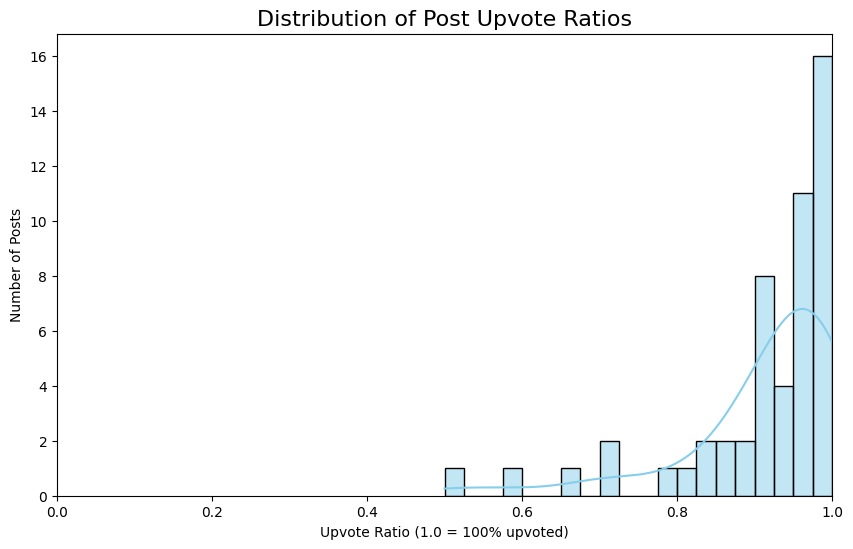

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_posts['upvote_ratio'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Post Upvote Ratios', fontsize=16)
plt.xlabel('Upvote Ratio (1.0 = 100% upvoted)')
plt.ylabel('Number of Posts')
plt.xlim(0, 1)
plt.show()

### Discussion Generation Analysis

Which posts sparked the most discussion relative to their upvote scores? This helps identify posts that generated meaningful conversation.

In [ ]:
df_posts['discussion_ratio'] = df_posts['num_comments'] / (df_posts['score'] + 1)
top_discussion_posts = df_posts.sort_values(by='discussion_ratio', ascending=False).head(5)
print("\n--- Top 5 Posts That Sparked the Most Discussion (Comments vs. Score)")
print(top_discussion_posts[['title', 'score', 'num_comments']])


--- Top 5 Posts That Sparked the Most Discussion (Comments vs. Score)
                                                title  score  num_comments
47  why are online sales now usually limited to th...      0             5
21                  Remaining Taylor's version albums      8            43
13  I tried to edit cover of the 1989 (Taylor's Ve...      3             6
2                1989 (Taylor’s Version) Announcement   1969          2842
39                   Vault Tracks: can someone ELI5??     18            26


### Comment Statistics

Basic overview of the comment dataset and user participation.

In [ ]:
print(f"Total comments for analysis: {len(df_comments)}")
print(f"Total unique users in the discussion: {df_comments['comment_author'].nunique()}")

Total comments for analysis: 4528
Total unique users in the discussion: 2468


### Comment Length Distribution

Are comments mostly short reactions or detailed thoughts? This helps understand the depth of community engagement.

In [ ]:
df_comments['comment_body'] = df_comments['comment_body'].fillna('')
df_comments['comment_length'] = df_comments['comment_body'].str.len()

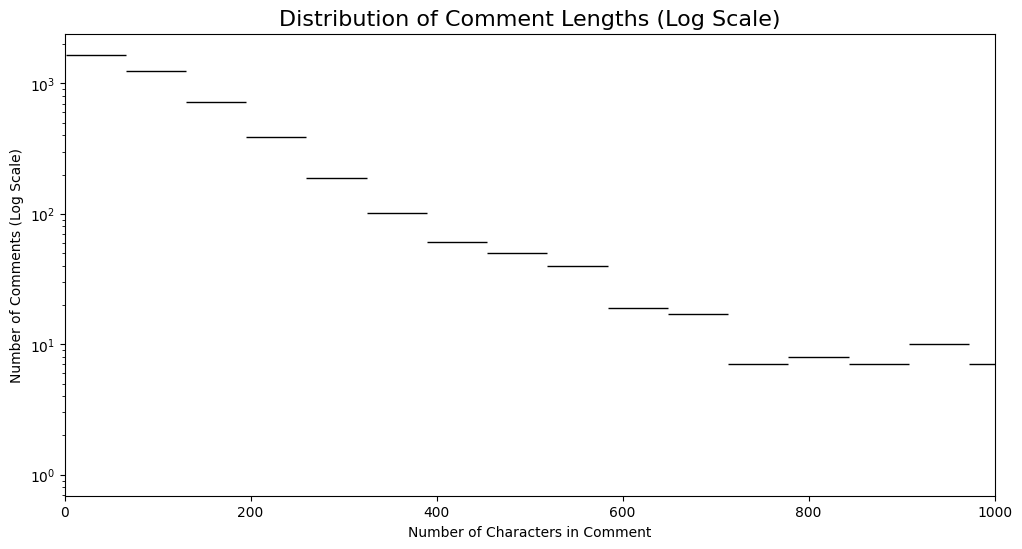

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df_comments['comment_length'], bins=50, color='coral', log_scale=(False, True))
plt.title('Distribution of Comment Lengths (Log Scale)', fontsize=16)
plt.xlabel('Number of Characters in Comment')
plt.ylabel('Number of Comments (Log Scale)')
plt.xlim(0, 1000)
plt.show()

### Thematic Word Cloud Analysis

What are the most common words and themes in the comments? This provides insight into what aspects of the announcement people are discussing most.

*Note: Words like "S" and "M" are prominent because Taylor released a Wordle game for fans to guess new track names a few days after the announcement.*

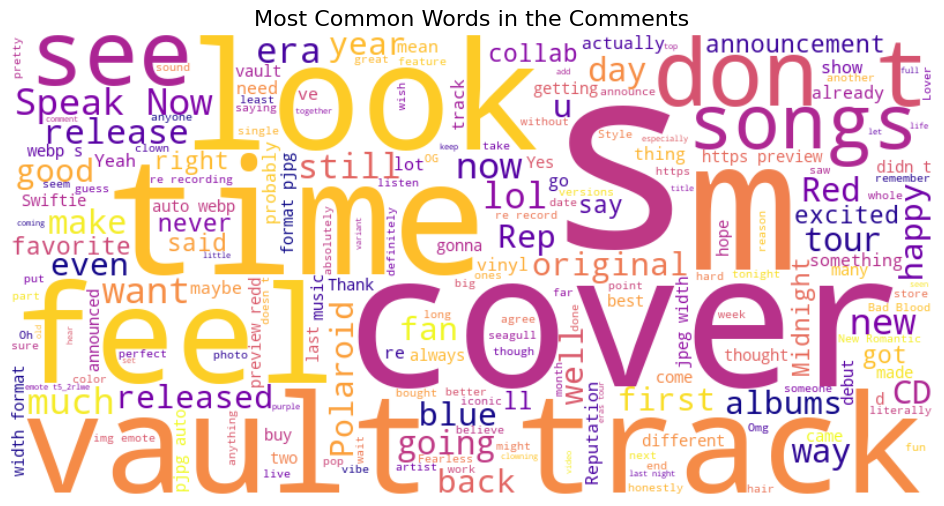

In [ ]:
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    'taylor', 'swift', '1989', 'version', 'album', 'tv', 'taylors', 'song', 'like',
    'im', 'one', 'get', 'think', 'know', 'really', 'will', 'people', 'dont', 'love'
])

text_for_cloud = " ".join(comment for comment in df_comments.comment_body.astype(str))

wordcloud = WordCloud(stopwords=custom_stopwords, background_color="white", width=800, height=400, colormap='plasma').generate(text_for_cloud)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most Common Words in the Comments', fontsize=16)
plt.show()


## Sentiment Analysis

Using VADER (Valence Aware Dictionary and sEntiment Reasoner) to analyze the emotional tone of comments and understand overall community sentiment.

In [ ]:
try:
    df_comments = pd.read_csv('reddit_1989_comments_dataset.csv')
    print("Comments dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'reddit_1989_comments_dataset.csv' not found.")
    exit()

Comments dataset loaded successfully.


In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
# calculation of sentiment scores for each comment

df_comments['sentiment_score'] = df_comments['comment_body'].astype(str).apply(
    lambda comment: analyzer.polarity_scores(comment)['compound']
)

In [ ]:
# categorizing each comment based on its score

def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [ ]:
df_comments['sentiment_category'] = df_comments['sentiment_score'].apply(categorize_sentiment)

/var/folders/db/vl4f65dd09lgbw9_cj6fdm5c0000gn/T/ipykernel_64621/1278220890.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=['#4CAF50', '#64B5F6', '#F44336']) # Green, Blue, Red


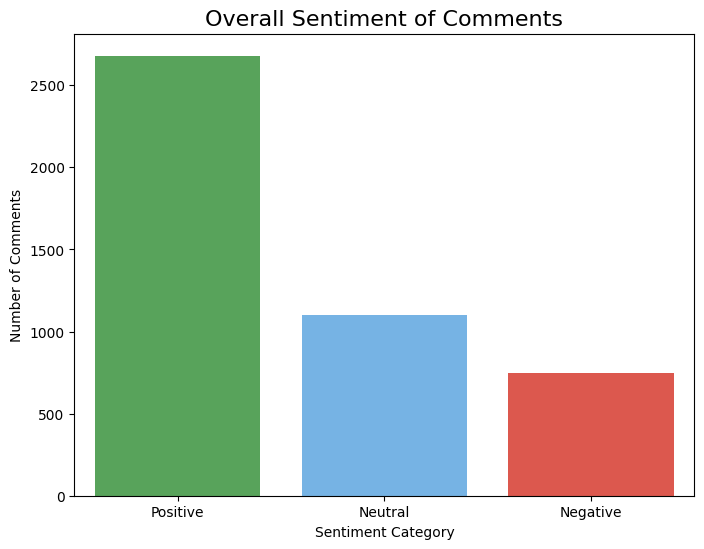

In [ ]:
plt.figure(figsize=(8, 6))
sentiment_counts = df_comments['sentiment_category'].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=['#4CAF50', '#64B5F6', '#F44336']) # Green, Blue, Red
plt.title('Overall Sentiment of Comments', fontsize=16)
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Comments')
plt.show()

In [ ]:
# sentiment breakdown
print(df_comments['sentiment_category'].value_counts(normalize=True) * 100)

sentiment_category
Positive    59.187279
Neutral     24.337456
Negative    16.475265
Name: proportion, dtype: float64


### Sentiment Analysis Results

**Overall Community Sentiment:**
- **Positive**: 59.2% of comments
- **Neutral**: 24.3% of comments
- **Negative**: 16.5% of comments

The community shows overwhelmingly positive sentiment toward the announcement!

## Network Analysis

Creating a social network graph where users are connected if they commented on the same posts. This helps identify communities and influential users within the discussion.

In [ ]:
G = nx.Graph()
grouped_by_post = df_comments.groupby('post_id')

Creating a list of unique authors/users for a specific post, and then looping through all of them to connect all the users who commented on it, and increasing the weight when these users interact with each other in more of the same threads.

In [ ]:
for post_id, group in grouped_by_post:
    authors_in_post = list(group['comment_author'].unique())

    for author1, author2 in itertools.combinations(authors_in_post, 2):
        if G.has_edge(author1, author2):
            G[author1][author2]['weight'] += 1
        else:
            G.add_edge(author1, author2, weight=1)

In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

In [ ]:
print(f"- {num_nodes} nodes (unique users)")
print(f"- {num_edges} edges (connections between users)")

- 2468 nodes (unique users)
- 334659 edges (connections between users)


In [ ]:
# calculating density to see how close the graph is to being complete

density = nx.density(G)
print(f"- Graph Density: {density:.4f}")

- Graph Density: 0.1099


### Network Statistics

**Network Overview:**
- **Nodes (users)**: 2,468 unique participants
- **Edges (connections)**: 334,659 connections between users
- **Graph Density**: 0.1099 (moderately connected network)

This indicates a well-connected community with many users interacting across multiple posts.

## Centrality Analysis

Next we calculate centrality to find the most influential or connected users, and then we detect communities using Louvain

In [ ]:
degree_centrality = nx.degree_centrality(G)
sorted_centrality = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)

### Most Influential Users

These users have the highest degree centrality, meaning they participated in discussions with the most other users. They represent key connectors in the community network.

In [ ]:
# top 10 most central users

for user, centrality in sorted_centrality[:10]:
    print(f"- {user}: {centrality:.4f}")

- pink_princess08: 0.6259
- CowboyLikeMegan: 0.5667
- Traditional-Egg-2656: 0.5460
- coltsmetsfan614: 0.4880
- fooledmeagain: 0.4820
- intoxicatedmidnight: 0.4722
- daniandkiara: 0.4645
- Rdickins1: 0.4621
- Vivid_Singer_7617: 0.4552
- ShesSpeakingNow: 0.4544


## Community Detection

In [ ]:
partition = community_louvain.best_partition(G)

In [ ]:
num_communities = len(set(partition.values()))
print(f"\nFound {num_communities} distinct communities in the network.")


Found 12 distinct communities in the network.


In [ ]:
df_comments['community'] = df_comments['comment_author'].map(partition)

In [ ]:
top_5_communities = df_comments['community'].value_counts().head(5)
top_5_communities

community
5    809
4    728
3    624
2    539
0    516
Name: count, dtype: int64

### Community Detection Results

**Network Communities:**
- **Total communities detected**: 12 distinct groups
- **Largest community**: 809 members
- **Second largest**: 728 members

These communities represent different sub-groups within the Taylor Swift fanbase, each with their own discussion patterns and interests.

## Targeted Keyword Analysis

Let's examine specific themes and topics that fans are discussing, including fan theories, easter eggs, and album imagery.

In [ ]:
keywords_to_track = {
    'Clowning/Theories': ['clown', 'clowning', 'theory', 'theories', 'mastermind'],
    'Hints/Easter Eggs': ['hint', 'hints', 'easter egg', 'clue', 'clues'],
    'The Color Blue': ['blue'],
    '1989 Imagery': ['seagull', 'seagulls']
}

In [ ]:
# finding mentions of the keywords in comments

def find_mentioned_themes(comment_body):
    comment_body = str(comment_body).lower()
    found_themes = []
    for theme, keywords in keywords_to_track.items():
        if any(re.search(r'\b' + keyword + r'\b', comment_body) for keyword in keywords):
            found_themes.append(theme)
    return found_themes if found_themes else None


In [ ]:
df_comments['mentioned_themes'] = df_comments['comment_body'].apply(find_mentioned_themes)

In [ ]:
df_themes = df_comments.dropna(subset=['mentioned_themes'])
print(f"\nFound {len(df_themes)} comments that mention at least one key theme.")


Found 439 comments that mention at least one key theme.


In [ ]:
df_theme_mentions = df_themes.explode('mentioned_themes')
most_mentioned_themes = df_theme_mentions['mentioned_themes'].value_counts()
most_mentioned_themes

mentioned_themes
The Color Blue       214
Clowning/Theories    140
1989 Imagery          77
Hints/Easter Eggs     42
Name: count, dtype: int64

In [ ]:
sentiment_per_theme = df_theme_mentions.groupby('mentioned_themes')['sentiment_score'].mean().sort_values(ascending=False)

### Theme Tracking Results

**Most Discussed Themes:**
- **The Color Blue**: 214 mentions (album's signature color)
- **Clowning/Theories**: 140 mentions (fan speculation)
- **1989 Imagery**: 77 mentions (seagulls, album aesthetics)
- **Hints/Easter Eggs**: 42 mentions (Taylor's cryptic clues)

Fans are particularly focused on the blue color theme and engaging in "clowning" (speculation about hidden meanings).

### Sentiment by Theme Analysis

This visualization shows how different discussion themes correlate with sentiment. Some topics generate more positive reactions than others.

/var/folders/db/vl4f65dd09lgbw9_cj6fdm5c0000gn/T/ipykernel_64621/496769758.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_per_theme.index, y=sentiment_per_theme.values, palette='viridis')


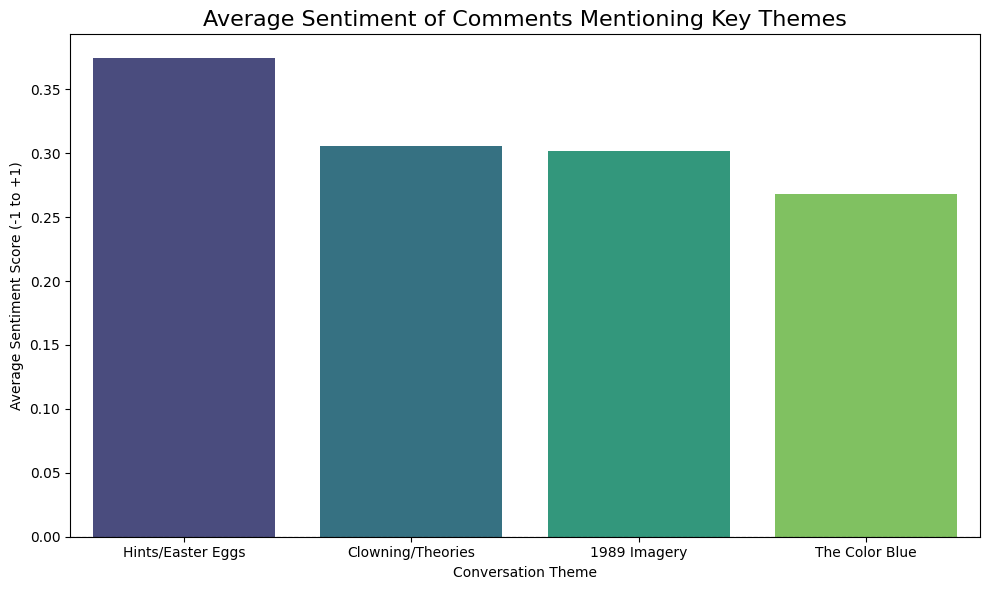

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_per_theme.index, y=sentiment_per_theme.values, palette='viridis')
plt.title('Average Sentiment of Comments Mentioning Key Themes', fontsize=16)
plt.xlabel('Conversation Theme')
plt.ylabel('Average Sentiment Score (-1 to +1)')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.tight_layout()
plt.show()

Bridging network analysis with sentiment analysis:
Did different fan communities show different overall sentiments in their comments?

## Community Sentiment Analysis

How do different fan communities differ in their emotional reactions? Let's examine sentiment patterns across the detected network communities.

In [ ]:
df_comments['community'] = df_comments['comment_author'].map(partition)
community_sentiment = df_comments.groupby('community')['sentiment_score'].mean().sort_values(ascending=False)
community_size = df_comments['community'].value_counts()

In [ ]:
df_community_summary = pd.DataFrame({
    'average_sentiment': community_sentiment,
    'number_of_comments': community_size
}).dropna().sort_values(by='number_of_comments', ascending=False)
df_community_summary.head(10)

,average_sentiment,number_of_comments
community,,
5,0.314012,809
4,0.329057,728
3,0.264017,624
2,0.254154,539
0,0.330400,516
6,0.239987,351
1,0.294122,288
8,0.161738,240
7,0.199704,221


/var/folders/db/vl4f65dd09lgbw9_cj6fdm5c0000gn/T/ipykernel_64621/2775691325.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_communities.index.astype(str), y=top_communities['average_sentiment'], palette='coolwarm_r')


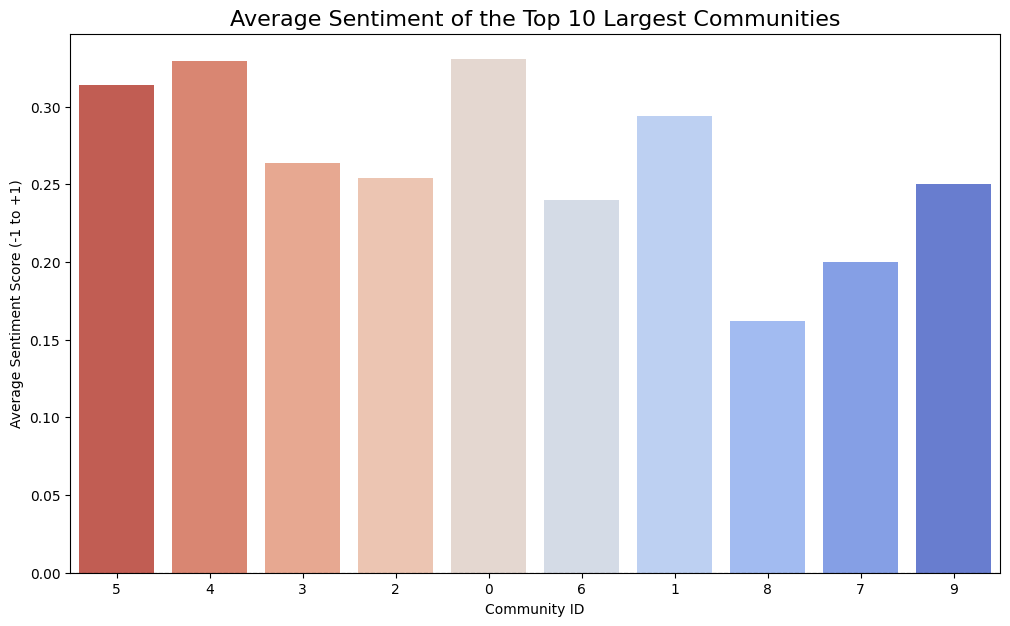

In [ ]:
top_communities = df_community_summary.head(10)
plt.figure(figsize=(12, 7))
sns.barplot(x=top_communities.index.astype(str), y=top_communities['average_sentiment'], palette='coolwarm_r')
plt.title('Average Sentiment of the Top 10 Largest Communities', fontsize=16)
plt.xlabel('Community ID')
plt.ylabel('Average Sentiment Score (-1 to +1)')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.show()

### Community Sentiment Results

Different communities show varying levels of positive sentiment, suggesting that sub-groups within the fanbase have different emotional responses to the announcement.

## Community Profiling

Let's take a deep dive into specific communities to understand who they are, what they're talking about, and what their most popular comments reveal.


--- Top 5 Most Active Authors in this Community ---
comment_author
sweetrebel88          10
bubblecuffer13         8
leilafornone           7
jonsnowme              6
nerdalertalertnerd     6
Name: count, dtype: int64

--- Generating Word Cloud for Community Topics ---


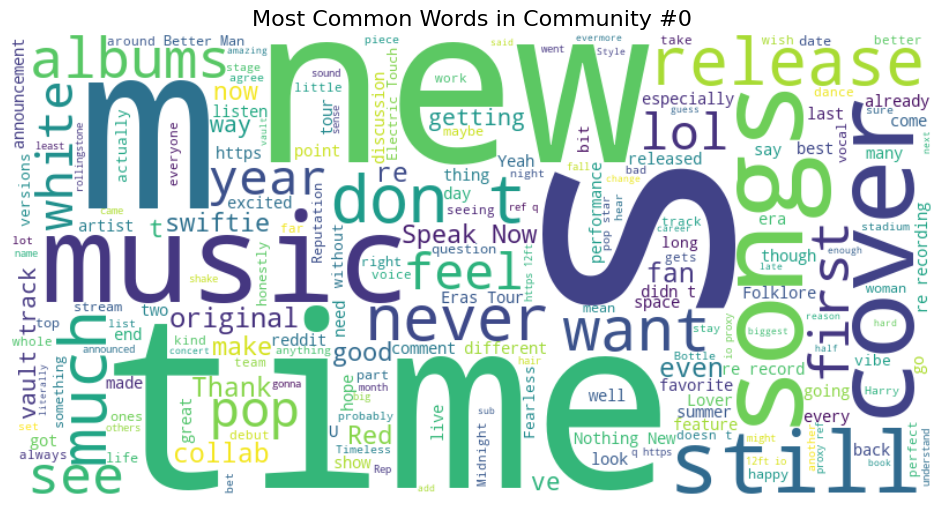


--- Top 5 Most Upvoted Comments in this Community ---
SCORE: 3795 | AUTHOR: canelones1
COMMENT: Like men do?

------------------------------------------------------------
SCORE: 2230 | AUTHOR: Disastrous-Bet8973
COMMENT: Doesn't Ed Sheeran just stand on stage? Yet I've heard how his shows are up there with the best ever. Why isn't he expected to dance?

------------------------------------------------------------
SCORE: 1145 | AUTHOR: TopsyOxy
COMMENT: I was very indifferent to the whole re-recording situation, but after checking out a handful of the Taylor Versions, I was surprised by how bad(?) A lot of them were. The mixing, engineering, and sound quality was off. I was always going to listen to the original ones, but listening to TV confirmed my position.

------------------------------------------------------------
SCORE: 1055 | AUTHOR: Darmop
COMMENT: So much this. I’ve been to her shows, and they are electric. Awkward dance moves not withstanding 🤣

----------------------------

In [ ]:
community_id_to_profile = 0
profile_df = df_comments[df_comments['community'] == community_id_to_profile]
if profile_df.empty:
    print(f"Community {community_id_to_profile} not found or has no comments.")
else:
    top_authors_in_community = profile_df['comment_author'].value_counts().head(5)
    print("\n--- Top 5 Most Active Authors in this Community ---")
    print(top_authors_in_community)

    print("\n--- Generating Word Cloud for Community Topics ---")

    custom_stopwords = set(STOPWORDS)
    custom_stopwords.update([
        'taylor', 'swift', '1989', 'version', 'album', 'tv', 'taylors', 'song', 'like',
        'im', 'one', 'get', 'think', 'know', 'really', 'will', 'people', 'dont', 'love'
    ])

    text_for_cloud = " ".join(comment for comment in profile_df.comment_body.astype(str))

    if text_for_cloud:
        wordcloud = WordCloud(stopwords=custom_stopwords, background_color="white", width=800, height=400, colormap='viridis').generate(text_for_cloud)

        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f'Most Common Words in Community #{community_id_to_profile}', fontsize=16)
        plt.show()
    else:
        print("No text available to generate a word cloud for this community.")

    top_5_comments = profile_df.nlargest(5, 'comment_score')

    print("\n--- Top 5 Most Upvoted Comments in this Community ---")
    for index, row in top_5_comments.iterrows():
        print(f"SCORE: {row['comment_score']} | AUTHOR: {row['comment_author']}")
        print(f"COMMENT: {row['comment_body']}\n")
        print("-" * 60)

### Community Profile Insights

This detailed analysis reveals the characteristics of specific communities, including their most active members, discussion topics, and highest-rated comments.

## Key Findings Summary

### Data Collection Results
- **Total Posts**: 52 posts within the target date range (August 9-16, 2023)
- **Total Comments**: 4,528 comments across all posts
- **Unique Users**: 2,468 unique users participating in discussions
- **Subreddits Analyzed**: r/TaylorSwift, r/TaylorSwiftPictures, r/popheads, r/Fauxmoi, r/popculturechat

### Sentiment Analysis Results
- **Positive Sentiment**: 59.2% of comments
- **Neutral Sentiment**: 24.3% of comments  
- **Negative Sentiment**: 16.5% of comments

### Network Analysis Results
- **Network Size**: 2,468 nodes (users) with 334,659 edges (connections)
- **Graph Density**: 0.1099 (moderately connected network)
- **Communities Detected**: 12 distinct communities
- **Largest Community**: 809 members

### Thematic Analysis Results
- **Most Discussed Theme**: "The Color Blue" (214 mentions)
- **Fan Theories**: "Clowning/Theories" (140 mentions)
- **Album Imagery**: "1989 Imagery" (77 mentions)
- **Easter Eggs**: "Hints/Easter Eggs" (42 mentions)

This analysis provides comprehensive insights into how the Reddit community reacted to Taylor Swift's 1989 (Taylor's Version) announcement, revealing patterns in sentiment, community formation, and thematic discussions across different fan communities.